In [1]:
!pip install evaluate
!pip install jiwer
# !pip install noisereduce
!pip install librosa pandas matplotlib seaborn soundfile tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [4]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import soundfile as sf
import torch
import os
import evaluate  # or from datasets import load_metric if older version
from tqdm import tqdm
import pandas as pd
# import noisereduce as nr
import librosa
import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence
import numpy as np

In [5]:
processor = AutoProcessor.from_pretrained("vinai/PhoWhisper-small")
model = AutoModelForSpeechSeq2Seq.from_pretrained("vinai/PhoWhisper-small")

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

In [8]:
# define function to read in sound file
# def map_to_array(batch):
#     speech, _ = sf.read(batch["file"])
#     batch["speech"] = speech
#     return batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def load_mp3_as_numpy(path_to_mp3):
    # Đọc file mp3
    audio = AudioSegment.from_mp3(path_to_mp3)

    # Chuyển thành mono và sample rate 16kHz
    audio = audio.set_channels(1).set_frame_rate(16000)

    # Lấy dữ liệu raw và chuyển sang numpy array
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)

    # Chuẩn hóa về khoảng [-1.0, 1.0] nếu cần
    samples /= np.iinfo(audio.array_type).max
    print(f"Chuyển đổi file: {path_to_mp3}")
    return samples, audio.frame_rate

def normalize_audio(y, target_rms=0.1):
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y * (target_rms / rms)
    return y

def segment_audio(y, sr, max_duration=5.0):
    max_len = int(sr * max_duration)
    total_len = len(y)
    return [y[i:i + max_len] for i in range(0, total_len, max_len)]



def testing(file_path, max_duration=5.0, target_rms=0.1):
    if file_path.lower().endswith('.mp3'):
        speech, sr = load_mp3_as_numpy(file_path)
    # Load waveform
    else: 
        # speech, _ = sf.read(file_path)
        # Load and preprocess audio
        speech, sr = librosa.load(file_path, sr=16000)
    
    # Step 1: Trim silence
    speech, _ = librosa.effects.trim(speech, top_db=30)

    # Step 2: Normalize RMS
    speech = normalize_audio(speech, target_rms=target_rms)

    # Step 3: Segment if needed
    duration = librosa.get_duration(y=speech, sr=sr)
    if duration <= max_duration:
        segments = [speech]
    else:
        segments = segment_audio(speech, sr=sr, max_duration=max_duration)

    # Step 4: ASR inference on each segment
    final_transcription = []
    for segment in segments:
        inputs = processor(
            audio=segment,
            return_tensors="pt",
            sampling_rate=16000,
            return_attention_mask=True 
        ).to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                inputs["input_features"],
                attention_mask=inputs.get("attention_mask")
            )

        # Decode and append
        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
        final_transcription.append(transcription[0].strip())

    # Step 5: Join final text
    output = " ".join(final_transcription).strip()
    print(output)
    return output

    # # Preprocess: Convert waveform to log-Mel spectrogram input
    # inputs = processor(
    #     audio=speech,
    #     return_tensors="pt",
    #     sampling_rate=16000
    # ).to(device)
    
    # # Generate predicted token IDs
    # with torch.no_grad():
    #     generated_ids = model.generate(inputs["input_features"])
    
    # # Decode into text
    # transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
    # return transcription

In [9]:
# Prepare output list
AUDIO_DIR = '/kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr'
CSV_PATH = '/kaggle/input/asr-private-test/prompts_asr.csv'
OUTPUT_CSV = '/kaggle/working/test_with_transcription.csv'

# Load CSV
df = pd.read_csv(CSV_PATH)

transcriptions = []

# Process each file
for filename in tqdm(df.iloc[:, 0]):  # Assuming first column has filenames
    wav_path = os.path.join(AUDIO_DIR, filename)
    if not os.path.exists(wav_path):
        transcriptions.append("FILE_NOT_FOUND")
        continue
    print(f"Testing file: {filename}")
    transcription = testing(wav_path)
    transcriptions.append(transcription)
df["transcription"] = transcriptions
df.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Transcriptions saved to {OUTPUT_CSV}")

  0%|          | 0/4268 [00:00<?, ?it/s]

Testing file: audio_0001.wav


  0%|          | 1/4268 [00:01<1:44:40,  1.47s/it]

những nước ấm chúng ta đắp lên cái vùng mắt.
Testing file: audio_0002.wav


  0%|          | 2/4268 [00:02<1:39:48,  1.40s/it]

chưa đủ bản lĩnh để ra đời đâu.
Testing file: audio_0003.wav


  0%|          | 3/4268 [00:04<1:35:22,  1.34s/it]

thế là chửi nhau.
Testing file: audio_0004.wav


  0%|          | 4/4268 [00:05<1:36:05,  1.35s/it]

được chứ em không đến đây vì một cái gì.
Testing file: audio_0005.wav


  0%|          | 5/4268 [00:06<1:38:02,  1.38s/it]

nông na như ông bà mình hay nói nó còn nhà lành nữa.
Testing file: audio_0006.wav


  0%|          | 6/4268 [00:08<1:42:22,  1.44s/it]

hoặc là cái nguồn từ cá các loại cá rất là tốt.
Testing file: audio_0007.wav


  0%|          | 7/4268 [00:10<1:45:32,  1.49s/it]

như là đài phát thanh của cộng hòa liên bang nga.
Testing file: audio_0008.wav


  0%|          | 8/4268 [00:11<1:47:12,  1.51s/it]

anh đâm hắn trọng thương rồi trốn biệt tăm.
Testing file: audio_0009.wav


  0%|          | 9/4268 [00:13<1:56:34,  1.64s/it]

tìm hiểu các thủ tục hoặc thông qua các đại diện sự công nghiệp để tiến hành đăng ký cho mình.
Testing file: audio_0010.wav


  0%|          | 10/4268 [00:15<1:55:47,  1.63s/it]

các bạn có cảm thấy là ngày hôm nay phong độ của mình tốt nhất không.
Testing file: audio_0011.wav


  0%|          | 11/4268 [00:17<2:01:30,  1.71s/it]

mà cô ấy nghĩ là quyến rũ của mình để dụ một thí sinh thì thúy thấy quá là buồn cười.
Testing file: audio_0012.mp3
Chuyển đổi file: /kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr/audio_0012.mp3


  0%|          | 12/4268 [00:18<1:57:55,  1.66s/it]

hôm đó tao phải ăn uống không.
Testing file: audio_0013.wav


  0%|          | 13/4268 [00:21<2:29:26,  2.11s/it]

hai cái thuộc tính là tên dự án và địa điểm của quan hệ dự án chúng ta sẽ có kết quả. là một quan hệ.
Testing file: audio_0014.wav


  0%|          | 14/4268 [00:24<2:53:24,  2.45s/it]

thằng hiếu tối nay qua nhà bà chơi thì thôi thôi thôi khỏi khỏi qua rồi mất công cái mạc con chi nó hầm hầm. unk á hổng được.
Testing file: audio_0015.wav


  0%|          | 15/4268 [00:29<3:34:06,  3.02s/it]

trên da bụng con ve có hai vật chuẩn gọi là âm cái nói chỉ cần cua bột. bom âm cái gọi là có thể thoát ra những tiếng kêu chói thai. n.
Testing file: audio_0016.wav


  0%|          | 16/4268 [00:30<3:02:56,  2.58s/it]

đấy là chị muốn mời hai em cùng quay trở lại hà nội với chị vào ngày mai.
Testing file: audio_0017.mp3
Chuyển đổi file: /kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr/audio_0017.mp3


  0%|          | 17/4268 [00:32<2:41:52,  2.28s/it]

hương thu còn thoảng đau đay bên hềm.
Testing file: audio_0018.wav


  0%|          | 18/4268 [00:34<2:28:48,  2.10s/it]

những bất cập của việc dạy và học tại việt nam trong hàng chục năm qua đã có giải pháp.
Testing file: audio_0019.wav


  0%|          | 19/4268 [00:37<2:45:31,  2.34s/it]

quý vị khán giả thân mến bắt đầu một ngày mới với tinh thần sảng khoái và sức khoẻ dồi dào sẽ khi. đến.
Testing file: audio_0020.wav


  0%|          | 20/4268 [00:41<3:40:40,  3.12s/it]

tức là chuyên gia phân tích dữ liệu thì đây là một cái vị trí được gọi là nhập. đặc môn của lĩnh vực kho dữ liệu và thường vị trí này thường dành cho những bạn sinh viên mới. mới ra trường mà thích về cái việc là kho dữ liệu hoặc là các cái tăng binh.
Testing file: audio_0021.mp3
Chuyển đổi file: /kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr/audio_0021.mp3


  0%|          | 21/4268 [00:43<3:03:21,  2.59s/it]

đúng là bà ấy.
Testing file: audio_0022.wav


  1%|          | 22/4268 [00:44<2:38:24,  2.24s/it]

điều lạ nhất là bất kể ai mua cũng có lời.
Testing file: audio_0023.wav


  1%|          | 23/4268 [00:47<2:46:29,  2.35s/it]

số phận của bờ và số phận người đàn ông kia là hai mảnh đời không trọn vẹn. n.
Testing file: audio_0024.wav


  1%|          | 24/4268 [00:48<2:23:09,  2.02s/it]

a mình có biện pháp nào á nhưng mà để mà.
Testing file: audio_0025.wav


  1%|          | 25/4268 [00:49<2:05:33,  1.78s/it]

thì ăn cơm dưới đất.
Testing file: audio_0026.wav


  1%|          | 26/4268 [00:51<1:53:30,  1.61s/it]

chắc chưa tha cho lần này nhé.
Testing file: audio_0027.wav


  1%|          | 27/4268 [00:52<1:49:18,  1.55s/it]

khi bỏ vào cái gì mà có cái lỗ lỗ lỗ lỗ đấy con biết không.
Testing file: audio_0028.wav


  1%|          | 28/4268 [00:57<2:54:06,  2.46s/it]

phép nối thuật ngữ tiếng anh là join là một phép toán quan trọng. đối với các cơ sở dữ liệu quan hệ có nhiều bảng bởi vì phép toán này cho phép chúng ta xử lý. các cái mối liên kết giữa các quan hệ.
Testing file: audio_0029.mp3
Chuyển đổi file: /kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr/audio_0029.mp3


  1%|          | 28/4268 [00:57<2:25:36,  2.06s/it]


KeyboardInterrupt: 

In [ ]:
# Step 2: Traverse .wav files and generate predictions
# y_true = []
# y_pred = []

# base_path = "/kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr"

# for root, _, files in os.walk(base_path):
#     for file in files:
#         if file.endswith(".wav"):
#             wav_path = os.path.join(root, file)
#             filename = os.path.splitext(file)[0]

#             # Read the audio
#             print(f"Testing file: {filename}")
#             transcription = testing(wav_path)
#             # speech, _ = sf.read(wav_path)
#             # input_values = processor(speech, return_tensors="pt", sampling_rate=16000).input_values

#             # # Inference
#             # with torch.no_grad():
#             #     logits = model(input_values).logits
#             #     predicted_ids = torch.argmax(logits, dim=-1)
#             #     transcription = processor.batch_decode(predicted_ids)[0].lower()

#             # Ground truth
#             if filename in gt_dict:
#                 # y_true.append(gt_dict[filename])
#                 y_pred.append(transcription)

In [ ]:
# Step 3: Calculate WER
# wer_metric = evaluate.load("wer")
# wer = wer_metric.compute(predictions=y_pred, references=y_true)
# print(f"WER: {wer:.3f}")


In [ ]:
# #Kiểm tra phân phối dữ liệu
# import os
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# from scipy.stats import ks_2samp, entropy

# #Hàm kiểm tra phân phối các đặc trưng âm thanh
# def extract_features(wav_path, sr=16000):
#     y, _ = librosa.load(wav_path, sr=sr)
#     return {
#         "duration": librosa.get_duration(y=y, sr=sr),
#         "energy": np.mean(y ** 2),
#         "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y)),
#         "mfcc_mean": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
#     }

# #Hàm load và tổng hợp đặc trưng của cả bộ dữ liệu
# def collect_features_from_dir(directory):
#     features = {
#         "duration": [],
#         "energy": [],
#         "zero_crossing_rate": [],
#         "mfcc": []
#     }

#     for file in os.listdir(directory):
#         if file.endswith(".wav"):
#             feat = extract_features(os.path.join(directory, file))
#             features["duration"].append(feat["duration"])
#             features["energy"].append(feat["energy"])
#             features["zero_crossing_rate"].append(feat["zero_crossing_rate"])
#             features["mfcc"].append(feat["mfcc_mean"])

#     features["mfcc"] = np.array(features["mfcc"])
#     return features

# #Hàm trực quan hóa và so sánh phân phối
# def compare_distributions(feat_pub, feat_priv, feature_name, title=None):
#     plt.figure(figsize=(8, 4))
#     sns.kdeplot(feat_pub, label="Public", fill=True)
#     sns.kdeplot(feat_priv, label="Private", fill=True)
#     plt.title(title or f"Distribution of {feature_name}")
#     plt.legend()
#     plt.show()

#     stat, p_value = ks_2samp(feat_pub, feat_priv)
#     print(f"Kolmogorov-Smirnov test for {feature_name}: stat={stat:.4f}, p-value={p_value:.4f}")

# #Hàm kiểm tra toàn diện và trực quan hóa
# def analyze_shift(public_dir, private_dir):
#     feat_pub = collect_features_from_dir(public_dir)
#     feat_priv = collect_features_from_dir(private_dir)

#     compare_distributions(feat_pub["duration"], feat_priv["duration"], "Duration (seconds)")
#     compare_distributions(feat_pub["energy"], feat_priv["energy"], "Signal Energy")
#     compare_distributions(feat_pub["zero_crossing_rate"], feat_priv["zero_crossing_rate"], "Zero Crossing Rate")

#     # So sánh MFCC từng chiều
#     for i in range(13):
#         compare_distributions(feat_pub["mfcc"][:, i], feat_priv["mfcc"][:, i], f"MFCC Coef {i}")

# path_to_private_dir = '/kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr'
# path_to_public_dir = '/kaggle/input/vivos-vietnamese/vivos/test/waves'
# analyze_shift("path/to/public_dir", "path/to/private_dir")

In [3]:
# import os
# import librosa
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm

# def collect_audio_files(root_dir, recursive=True):
#     wav_files = []
#     if recursive:
#         for subdir, _, files in os.walk(root_dir):
#             for file in files:
#                 if file.endswith('.wav'):
#                     wav_files.append(os.path.join(subdir, file))
#     else:
#         for file in os.listdir(root_dir):
#             if file.endswith('.wav'):
#                 wav_files.append(os.path.join(root_dir, file))
#     return wav_files

# def extract_audio_features(file_path):
#     try:
#         y, sr = librosa.load(file_path, sr=None, mono=False)
#         duration = librosa.get_duration(y=y, sr=sr)
#         channels = 1 if len(y.shape) == 1 else y.shape[0]
#         rms = librosa.feature.rms(y=y).mean()
#         return {
#             'path': file_path,
#             'sample_rate': sr,
#             'duration_sec': duration,
#             'channels': channels,
#             'rms_energy': rms
#         }
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return None

# def analyze_datasets(public_root, private_root):
#     public_files = collect_audio_files(public_root, recursive=True)
#     private_files = collect_audio_files(private_root, recursive=False)

#     print(f"Found {len(public_files)} public test files")
#     print(f"Found {len(private_files)} private test files")

#     public_data = [extract_audio_features(f) for f in tqdm(public_files, desc="Public test")]
#     private_data = [extract_audio_features(f) for f in tqdm(private_files, desc="Private test")]

#     df_public = pd.DataFrame([x for x in public_data if x])
#     df_private = pd.DataFrame([x for x in private_data if x])

#     df_public['set'] = 'public'
#     df_private['set'] = 'private'
#     df_all = pd.concat([df_public, df_private], ignore_index=True)

#     return df_all

Found 760 public test files
Found 4013 private test files


Private test: 100%|██████████| 4013/4013 [01:20<00:00, 49.74it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_31/2907475641.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feature, hue='set', fill=True)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-

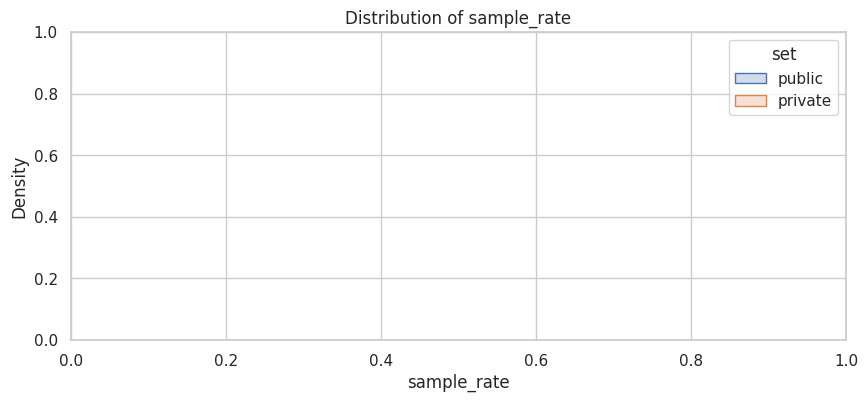

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

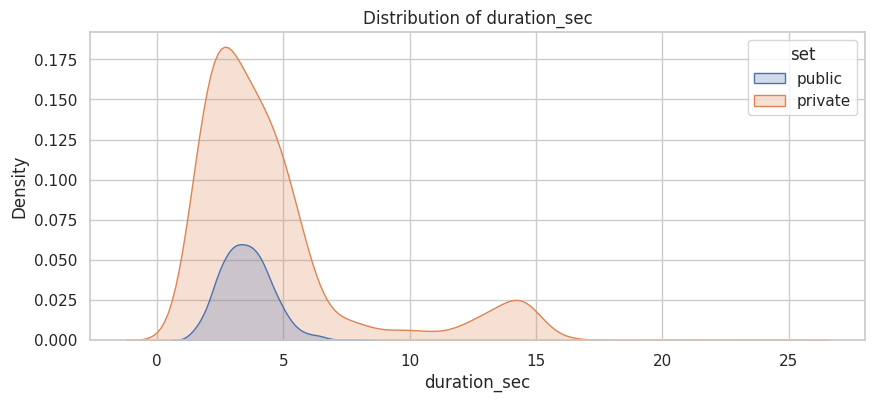

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

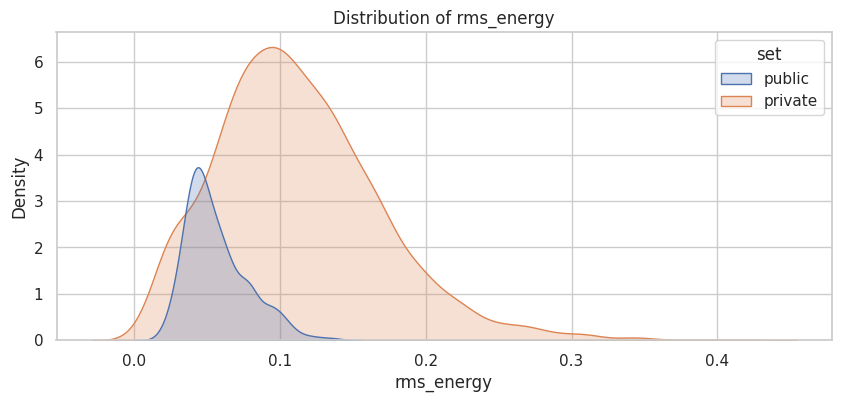

        sample_rate      duration_sec           rms_energy           channels
               mean  std         mean       std       mean       std  nunique
set                                                                          
private     16000.0  0.0     4.591103  3.391334   0.112459  0.056737        1
public      16000.0  0.0     3.533611  0.997631   0.056308  0.021364        1


In [4]:
# # Run analysis
# public_root = "/kaggle/input/vivos-vietnamese/vivos/test/waves"
# private_root = "/kaggle/input/asr-private-test/private-test-data-asr-20250515T144327Z-1-001/private-test-data-asr"
# df = analyze_datasets(public_root, private_root)

# # 📊 Visualize
# sns.set(style="whitegrid")
# for feature in ['sample_rate', 'duration_sec', 'rms_energy']:
#     plt.figure(figsize=(10, 4))
#     sns.kdeplot(data=df, x=feature, hue='set', fill=True)
#     plt.title(f"Distribution of {feature}")
#     plt.show()

# # Optional: print basic statistics
# print(df.groupby('set').agg({
#     'sample_rate': ['mean', 'std'],
#     'duration_sec': ['mean', 'std'],
#     'rms_energy': ['mean', 'std'],
#     'channels': pd.Series.nunique
# }))
